Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Installing Required Packages

In [ ]:
!pip install ultralytics optuna category_encoders feature-engine scikeras

Environment Setup and Data Preparation

In [ ]:
# Step 1: Environment Setup and Data Preparation
# -----------------------------------------------

# Standard Libraries
import os
from types import SimpleNamespace

# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Image Processing
import cv2
from PIL import Image
from skimage import measure
from skimage.morphology import skeletonize
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

# Machine Learning and Deep Learning
import torch
from torchvision import models, transforms
from ultralytics import YOLO
import ultralytics

# Visualization
import matplotlib.pyplot as plt

# Machine Learning Utilities
from sklearn.model_selection import train_test_split, RepeatedKFold, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import (
    StandardScaler, QuantileTransformer, PolynomialFeatures, OneHotEncoder
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.pipeline import Pipeline

# Optimization
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from optuna import Trial

# Advanced Machine Learning Libraries
from xgboost import XGBRegressor, callback
from lightgbm import LGBMRegressor

# Signal Processing
from scipy.signal import savgol_filter

# File and Directory Operations
import zipfile
import glob


%matplotlib inline


 Data Extraction and CSV Loading

In [ ]:
# Extract Director
extract_dir = '/content/drive/MyDrive/CGIR'


# The CSV files are stored inside the data/ directory.
train_csv_path = os.path.join(extract_dir, 'Train.csv')
test_csv_path  = os.path.join(extract_dir, 'Test.csv')

df_train = pd.read_csv(train_csv_path)
df_test  = pd.read_csv(test_csv_path)


In [ ]:
#Drop Zero RootVolume Rows
df_train = df_train[df_train["RootVolume"] != 0].copy()


In [ ]:
df_test

,ID,FolderName,PlantNumber,Side,Start,End,Genotype,Stage
0,ID_208667_Hnkl8q,L5l1h3kekg,7,L,38,50,IITA-TMS-IBA000070,Early
1,ID_285249_Jnjvav,Wgutyon8uu,6,R,23,37,TMEB419,Early
2,ID_697947_Yec6bd,Mylwjeq6tq,3,R,19,42,IBA980581,Early
3,ID_534638_X3j91f,Pfp24vx905,2,R,27,34,TMEB419,Early
4,ID_929298_Xvymuz,Mrw7chmalv,4,R,30,43,IBA154810,Early
...,...,...,...,...,...,...,...,...
125,ID_652025_Ecubfg,L8w7zu7wek,4,L,33,51,IITA-TMS-IBA000070,Early
126,ID_456856_Iucagp,Klhqlr0ako,2,L,38,47,TMEB693,Early
127,ID_163551_Alfdb5,Vlqr6qhbqk,3,L,48,55,IBA154810,Early
128,ID_947929_Qsuqln,Pfp24vx905,5,R,27,34,TMEB419,Early


In [ ]:
df_train['PlantID'] = df_train['ID']
df_test['PlantID'] = df_test['ID']

Unzipping the Main Dataset and Models

In [ ]:
# ----- Unzip the main dataset (data.zip) -----
data_zip_path = '/content/drive/MyDrive/CGIR/data.zip'
data_extract_dir = '/content/data'  # This will be our root folder for the dataset

if not os.path.exists(data_extract_dir):
    print("Extracting dataset from", data_zip_path)
    with zipfile.ZipFile(data_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_extract_dir)
    print("Dataset extraction complete!")
else:
    print("Dataset already extracted in", data_extract_dir)

# ----- Unzip the models (Models.zip) -----
models_zip_path = '/content/drive/MyDrive/CGIR/Models.zip'
models_extract_dir = '/content/Models'  # This folder should be created after extraction

if not os.path.exists(models_extract_dir):
    print("Extracting models from", models_zip_path)
    with zipfile.ZipFile(models_zip_path, 'r') as zip_ref:
        zip_ref.extractall()  # Extracts to current directory; creates Models/ folder
    print("Models extraction complete!")
else:
    print("Models already extracted in", models_extract_dir)


Listing and Verifying Dataset Structure

In [ ]:
# List top-level folders in the dataset (should be 'train' and 'test')
top_folders = [d for d in os.listdir(data_extract_dir) if os.path.isdir(os.path.join(data_extract_dir, d))]
print("Top-level folders found in dataset:", top_folders)

# For each top-level folder, list unique subfolders and count images within them.
for top_folder in top_folders:
    top_folder_path = os.path.join(data_extract_dir, top_folder)
    subfolders = [d for d in os.listdir(top_folder_path) if os.path.isdir(os.path.join(top_folder_path, d))]
    print(f"\nFolder '{top_folder}' contains {len(subfolders)} subfolders:")
    for subfolder in subfolders:
        subfolder_path = os.path.join(top_folder_path, subfolder)
        images = glob.glob(os.path.join(subfolder_path, '*.png'))
        print(f"  Subfolder '{subfolder}': {len(images)} images")

Visualizing Sample Images

Displaying sample images from subfolder: Mskdmpitqk


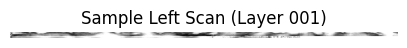

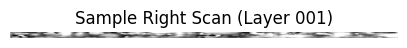

In [ ]:
# ------------------------------------------------------------------------------
# Step 3: Visualize Sample Images
# ------------------------------------------------------------------------------

def show_image(img_path, title=None,width=5,height=5):
    """Load and display an image given its path."""
    img = cv2.imread(img_path)
    if img is None:
        print("Image not found:", img_path)
        return
    # Convert BGR (OpenCV default) to RGB for display.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(width, height))
    plt.imshow(img_rgb)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# For demonstration, select a sample subfolder from the 'train' directory.
sample_train_dir = os.path.join(data_extract_dir, 'train')
sample_subfolders = [d for d in os.listdir(sample_train_dir) if os.path.isdir(os.path.join(sample_train_dir, d))]
if sample_subfolders:
    sample_subfolder = sample_subfolders[0]
    sample_subfolder_path = os.path.join(sample_train_dir, sample_subfolder)
    # Construct sample image names using the naming convention:
    #   {subfolder}_{S}_{layer:03d}.png
    sample_left_image = os.path.join(sample_subfolder_path, f"{sample_subfolder}_L_001.png")
    sample_right_image = os.path.join(sample_subfolder_path, f"{sample_subfolder}_R_001.png")
    print("Displaying sample images from subfolder:", sample_subfolder)
    show_image(sample_left_image, "Sample Left Scan (Layer 001)")
    show_image(sample_right_image, "Sample Right Scan (Layer 001)")
else:
    print("No subfolders found in train directory.")

Model Loading Function

In [ ]:

# ----------------------------
# Model Loading
# ----------------------------

def load_segmentation_model(model_path):
    """Load YOLOv8 segmentation model"""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    return YOLO(model_path)

# Initialize models
model_e = load_segmentation_model(os.path.join(models_extract_dir, 'best_early.pt'))
model_l = load_segmentation_model(os.path.join(models_extract_dir, 'best_late.pt'))

# ----------------------------
# Core Segmentation Functions
# ----------------------------

def segment_roots(image_path, model):
    """Robust root segmentation with mask combination"""
    img = cv2.imread(image_path)
    if img is None:
        return np.zeros((640, 640), dtype=np.uint8)

    results = model.predict(img, conf=0.3, imgsz=640, verbose=False)

    if not results or not results[0].masks:
        return np.zeros(img.shape[:2], dtype=np.uint8)

    combined_mask = np.any(results[0].masks.data.cpu().numpy() > 0.5, axis=0)
    return combined_mask.astype(np.uint8) * 255

def calculate_area(mask):
    """Calculate valid root area with noise filtering"""
    if mask is None or np.sum(mask) < 100:  # Ignore small noisy areas
        return 0
    return np.sum(mask > 0)

# ----------------------------
# Feature Extraction Functions
# ----------------------------
def morphological_features(mask):
    """Extract morphological features with segment-wise analysis"""
    mask_bin = (mask > 0).astype(np.uint8)
    features = {}

    # Skeleton analysis
    skeleton = skeletonize(mask_bin)
    features['SkeletonLength'] = np.sum(skeleton)

    # Initialize region analysis
    labeled_mask = measure.label(mask_bin)
    regions = measure.regionprops(labeled_mask)

    # Thickness and shape analysis
    thickness_values = []
    eccentricities = []
    area_values = []

    for region in regions:
        if region.area >= 100:  # Match noise threshold
            # Thickness calculation
            segment_mask = (labeled_mask == region.label)
            segment_skeleton = skeletonize(segment_mask)
            skel_length = np.sum(segment_skeleton)
            if skel_length > 0:
                thickness_values.append(region.area / skel_length)

            # Shape characteristics
            eccentricities.append(region.eccentricity)
            area_values.append(region.area)

    # Thickness features
    features['AvgThickness'] = np.sum(mask_bin)/features['SkeletonLength'] if features['SkeletonLength'] > 0 else 0
    features['MeanThickness'] = np.mean(thickness_values) if thickness_values else 0

    # Shape features
    features['MeanShapeEccentricity'] = np.mean(eccentricities) if eccentricities else 0
    features['MeanShapeArea'] = np.mean(area_values) if area_values else 0
    # Contour analysis
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        main_contour = max(contours, key=cv2.contourArea)
        features['ContourArea'] = cv2.contourArea(main_contour)
        features['ContourPerimeter'] = cv2.arcLength(main_contour, True)
        features['ContourComplexity'] = features['ContourPerimeter']**2 / (4*np.pi*features['ContourArea']) if features['ContourArea'] > 0 else 0

        # Calculate mean shape area of significant contours
        all_areas = [cv2.contourArea(cnt) for cnt in contours]
        significant_areas = [a for a in all_areas if a >= 100]  # Match area threshold from calculate_area()
        features['MeanShapeArea'] = np.mean(significant_areas) if significant_areas else 0
    else:
        features.update({
            'ContourArea': 0,
            'ContourPerimeter': 0,
            'ContourComplexity': 0,
            'MeanShapeArea': 0
        })

    return features

#--------------------------------------
# Texture Features
#--------------------------------------
def texture_features(mask):
    """Enhanced texture analysis with segment-wise GLCM"""
    mask_bin = (mask > 0).astype(np.uint8)
    features = {}

    # Initialize region analysis
    labeled_mask = measure.label(mask_bin)
    regions = measure.regionprops(labeled_mask)

    # GLCM features per segment
    contrast_values = []
    homogeneity_values = []

    for region in regions:
        if region.area >= 100:
            # Extract segment image
            minr, minc, maxr, maxc = region.bbox
            segment_img = mask_bin[minr:maxr, minc:maxc]

            # Calculate GLCM properties
            glcm = graycomatrix(segment_img, [1], [0], symmetric=True, normed=True)
            contrast_values.append(graycoprops(glcm, 'contrast')[0, 0])
            homogeneity_values.append(graycoprops(glcm, 'homogeneity')[0, 0])

    # Texture means
    features['MeanTextureContrast'] = np.mean(contrast_values) if contrast_values else 0
    features['MeanTextureHomogeneity'] = np.mean(homogeneity_values) if homogeneity_values else 0

    # LBP analysis
    img = (mask_bin * 255).astype(np.uint8)
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    features['MeanLBP'] = np.mean(lbp)

    # GLCM features
    glcm = graycomatrix(img, [1], [0], symmetric=True, normed=True)
    features['GLCM_Contrast'] = graycoprops(glcm, 'contrast')[0, 0]
    features['GLCM_Correlation'] = graycoprops(glcm, 'correlation')[0, 0]
    features['GLCM_Energy'] = graycoprops(glcm, 'energy')[0, 0]
    features['GLCM_Homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]

    # LBP features
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp, bins=np.arange(0, 10), density=True)
    features.update({f'LBP_{i}': hist[i] for i in range(9)})

    return features

def fractal_dimension(mask):
    """Box-counting fractal dimension with corrected implementation"""
    def boxcount(z, k):
        """Properly nested reduceat calls"""
        # Reduce along rows first
        row_reduced = np.add.reduceat(z, np.arange(0, z.shape[0], k), axis=0)
        # Then reduce along columns
        return np.add.reduceat(row_reduced, np.arange(0, z.shape[1], k), axis=1)

    mask_bin = (mask > 0).astype(int)
    if 0 in mask_bin.shape or np.sum(mask_bin) == 0:
        return 0.0

    try:
        max_size = int(np.log2(min(mask_bin.shape)))
        sizes = 2**np.arange(max_size, 1, -1)
    except ValueError:
        return 0.0

    counts = []
    for size in sizes:
        if size >= min(mask_bin.shape):
            continue
        bc = boxcount(mask_bin, size)
        counts.append(np.sum(bc > 0))

    if len(counts) < 2:
        return 0.0

    # Safely handle log calculations
    with np.errstate(divide='ignore', invalid='ignore'):
        x = np.log(sizes[:len(counts)])
        y = np.log(np.array(counts) + 1e-10)
        coeffs = np.polyfit(x, y, 1)

    return float(-coeffs[0])

# ----------------------------
# mean fractal dimension
# ----------------------------
def mean_fractal_dimension(mask):
    """Calculate mean fractal dimension across root segments"""
    mask_bin = (mask > 0).astype(int)
    labeled = measure.label(mask_bin)
    regions = measure.regionprops(labeled)

    fd_values = []
    for region in regions:
        if region.area >= 100:
            segment_mask = (labeled == region.label).astype(np.uint8)
            fd = fractal_dimension(segment_mask)
            fd_values.append(fd)

    return np.mean(fd_values) if fd_values else 0


# ----------------------------
# Deep Feature Extraction
# ----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True).eval().to(device)
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
deep_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def deep_features(image_path):
    """Extract deep features from pretrained ResNet"""
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = deep_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            features = feature_extractor(img_tensor)
        return features.cpu().numpy().flatten()
    except:
        return np.zeros(512)  # Fallback for ResNet18 features

# ----------------------------
# Modified Stereo Processing
# ----------------------------

def process_stereo_pair(left_path, right_path):
    """Updated stereo processing with deep feature averaging"""
    # Disparity calculation
    disparity = compute_disparity_sgbm(left_path, right_path)

    features = {'Disparity': disparity}
    deep_values = []

    # Process left view
    if left_path and os.path.exists(left_path):
        left_deep = deep_features(left_path)
        features.update({f'Left_{i}': v for i, v in enumerate(left_deep)})
        deep_values.extend(left_deep)

    # Process right view
    if right_path and os.path.exists(right_path):
        right_deep = deep_features(right_path)
        features.update({f'Right_{i}': v for i, v in enumerate(right_deep)})
        deep_values.extend(right_deep)

    # Calculate mean of all deep features
    features['MeanDeepFeature'] = np.mean(deep_values) if deep_values else 0

    return features


def compute_disparity_sgbm(left_path, right_path):
    """Robust disparity calculation with auto-scaling"""
    left = cv2.imread(left_path, 0)
    right = cv2.imread(right_path, 0)

    if left is None or right is None:
        return 0

    # Auto-resize to smallest common size
    h, w = min(left.shape[0], right.shape[0]), min(left.shape[1], right.shape[1])
    left = cv2.resize(left, (w, h))
    right = cv2.resize(right, (w, h))

    # Configure stereo matcher
    window_size = 5
    matcher = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=64,
        blockSize=window_size,
        P1=8*3*window_size**2,
        P2=32*3*window_size**2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32
    )

    disparity = matcher.compute(left, right).astype(np.float32)/16
    return np.mean(disparity[disparity > 0]) if np.any(disparity > 0) else 0



def calculate_3d_metrics(disparities, areas):
    """Calculate voxel-based 3D features"""
    voxel_volume = np.sum(areas) * np.mean(disparities)
    surface_area = np.sum([np.sqrt(area) for area in areas])  # Approximate surface area
    return {
        'VoxelVolume': voxel_volume,
        'SurfaceArea3D': surface_area,
        'Compactness3D': voxel_volume / (surface_area + 1e-6)
    }


# ----------------------------
# Complete Feature Estimation
# ----------------------------
def extract_plant_features(folder_path, plant_info):
    """Complete feature extraction pipeline"""
    features = {}
    layer_features = []
    disparities = []

    for layer in range(plant_info['Start'], plant_info['End'] + 1):
        left_path = os.path.join(folder_path, f"{plant_info['FolderName']}_L_{layer:03d}.png")
        right_path = os.path.join(folder_path, f"{plant_info['FolderName']}_R_{layer:03d}.png")

        # Select appropriate model
        model = model_e if plant_info['Stage'] == 'Early' else model_l

        # Process left view
        left_mask = segment_roots(left_path, model) if os.path.exists(left_path) else None
        left_area = calculate_area(left_mask) if left_mask is not None else 0

        # Process right view
        right_mask = segment_roots(right_path, model) if os.path.exists(right_path) else None
        right_area = calculate_area(right_mask) if right_mask is not None else 0

        # Layer statistics
        layer_area = left_area + right_area

        # Get the best mask (view with higher area)
        best_mask = left_mask if left_area > right_area else right_mask

        # Calculate features
        morpho_features = morphological_features(best_mask)
        texture_features_result = texture_features(best_mask)
        fractal_dim = fractal_dimension(best_mask)
        mean_fractal_dim = mean_fractal_dimension(best_mask)

        # Create layer entry
        layer_entry = {
            'Layer': layer,
            'TotalArea': layer_area,
            **morpho_features,
            **texture_features_result,
            'FractalDimension': fractal_dim,
            'MeanFractalDimension': mean_fractal_dim
        }

        # Process stereo features
        if os.path.exists(left_path) and os.path.exists(right_path):
            stereo_features = process_stereo_pair(left_path, right_path)
            disparities.append(stereo_features.pop('Disparity'))
            layer_entry.update(stereo_features)
        else:
            # Handle single-view deep features
            deep_vals = []
            if os.path.exists(left_path):
                deep_vals.extend(deep_features(left_path))
            if os.path.exists(right_path):
                deep_vals.extend(deep_features(right_path))
            layer_entry['MeanDeepFeature'] = np.mean(deep_vals) if deep_vals else 0

        layer_features.append(layer_entry)

    # Handle case with no valid layers
    if not layer_features:
        return features

    # Calculate temporal features
    areas = [lf['TotalArea'] for lf in layer_features]
    disparities_array = np.array(disparities)

    # Add to feature aggregation: 3D Spatial Features
    features.update(calculate_3d_metrics(disparities_array, areas))

    # Smooth area progression and calculate derivatives
    smoothed_areas = savgol_filter(areas, window_length=5, polyorder=2)
    features.update({
        'AreaGrowthRate': np.mean(np.diff(smoothed_areas)),
        'AreaAcceleration': np.mean(np.diff(smoothed_areas, 2))
    })

    # Calculate volume
    volume = 0
    if len(areas) > 1:
        thickness = np.abs(np.diff(disparities_array)) if len(disparities_array) > 1 else np.ones(len(areas)-1)
        if np.mean(thickness) > 0:
            thickness = thickness / np.mean(thickness)
        volume = sum((areas[i] + areas[i+1])/2 * thickness[min(i, len(thickness)-1)]
                   for i in range(len(areas)-1))

    # Aggregate features
    features.update({
        'EstimatedVolume': volume,
        'TotalArea': sum(areas),
        'MaxLayerArea': max(areas) if areas else 0,
        'AreaVariance': np.var(areas) if areas else 0,
        'MeanDisparity': np.mean(disparities_array) if disparities_array.size > 0 else 0,
        'DisparityRange': np.ptp(disparities_array) if disparities_array.size > 0 else 0,
        'NumActiveLayers': sum(a > 0 for a in areas),
        **{k: np.mean([lf[k] for lf in layer_features]) for k in layer_features[0].keys() if k != 'Layer'}
    })

    # Add metadata
    features.update({
        'Genotype': plant_info['Genotype'],
        'Stage': plant_info['Stage'],
        'PlantID': plant_info['PlantID'],
    })
    if 'RootVolume' in plant_info:
        features['RootVolume'] = plant_info['RootVolume']

    return features


# ----------------------------
# Main Processing Loop
# ----------------------------

def process_all_plants(df, data_dir):
    """Process all plants in the dataframe"""
    results = []

    for idx, row in df.iterrows():
        subfolder = find_subfolder_path(row['FolderName'], data_dir)
        if subfolder is None:
            continue

        try:
            features = extract_plant_features(subfolder, row)
            results.append(features)
        except Exception as e:
            print(f"Error processing process_all_plants {row['FolderName']}: {str(e)}")

    return pd.DataFrame(results).fillna(0)

# Utility function to locate image folders
def find_subfolder_path(folder_name, base_dir):
    for root, dirs, _ in os.walk(base_dir):
        if folder_name in dirs:
            return os.path.join(root, folder_name)
    return None

In [ ]:
# Process all plants
feature_df = process_all_plants(df_train, '/content/data/train/')

 MIN ON GOOGLE COLAB T4 GPU

In [ ]:
# Process all plants
feature_test_df = process_all_plants(df_test, '/content/data/test/')

In [ ]:
feature_df

,VoxelVolume,SurfaceArea3D,Compactness3D,AreaGrowthRate,AreaAcceleration,EstimatedVolume,TotalArea,MaxLayerArea,AreaVariance,MeanDisparity,...,Right_507,Right_508,Right_509,Right_510,Right_511,MeanDeepFeature,Genotype,Stage,PlantID,RootVolume
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,32.495552,...,0.576510,0.248420,3.743573,0.846082,0.011881,0.461605,IITA-TMS-IBA000070,Early,ID_826322_Lbmaya,0.9
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,33.182064,...,0.457566,0.285035,2.906474,1.223164,0.007405,0.476454,IBA154810,Early,ID_718181_Bslpwx,1.5
2,80267.226929,138.358443,580.139705,13.844898,4.761905,1956.691944,308.000000,416,8240.000000,32.575985,...,1.014203,0.264335,2.468823,1.722663,0.002793,0.466493,IBA980581,Early,ID_465762_L1n61d,2.7
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,34.288719,...,0.591543,0.264968,2.767678,1.207530,0.010972,0.412282,IITA-TMS-IBA000070,Early,ID_626872_Pbmx2e,2.6
4,123197.070786,195.071676,631.547708,-52.292063,2.435714,3870.098591,425.200000,720,61349.960000,28.973911,...,1.990822,0.428204,2.106300,2.101239,0.003100,0.525258,IBA980581,Early,ID_518846_Opko8c,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,29.448387,...,0.666542,0.310580,1.921530,1.161522,0.012908,0.443602,TMEB419,Early,ID_592215_Hfzzen,2.2
378,77156.076126,140.022208,551.027419,19.285714,-10.831429,2741.636384,209.083333,505,28598.909722,30.751724,...,0.955508,0.472778,2.505512,1.116917,0.011191,0.427826,IBA154810,Early,ID_995502_L5bkz9,1.3
379,35350.380615,82.112947,430.509215,12.497143,-22.146032,934.371113,104.727273,272,11090.925620,30.686094,...,1.609816,0.247167,2.186234,1.638961,0.009094,0.478679,IBA980581,Early,ID_490708_Isn2o5,4.8
380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,33.418339,...,0.407477,0.070330,3.391841,1.403381,0.037581,0.458121,IBA154810,Early,ID_899134_Gyrlfg,1.3


In [ ]:


def create_interaction_features(df):
    """Advanced feature engineering with validation checks"""
    # Create copy to avoid modifying original dataframe
    df = df.copy()

    # Check for required base columns
    required_columns = [
        'EstimatedVolume', 'MeanShapeArea', 'MeanTextureContrast',
        'MeanTextureHomogeneity', 'MeanShapeEccentricity',
        'MeanFractalDimension', 'MeanLBP', 'MeanThickness',
        'MeanDeepFeature', 'AvgThickness'
    ]

    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    try:
        # Biological interaction terms
        df['Volumetric_Density'] = df['EstimatedVolume'] / (df['MeanShapeArea'].replace(0, 1e-6))
        df['Texture_Complexity'] = df['MeanTextureContrast'] * df['MeanTextureHomogeneity']
        df['MorphoBalance'] = (df['MeanShapeEccentricity'] * df['MeanFractalDimension']) / df['MeanLBP'].replace(0, 1e-6)

        # Polynomial features with validation
        poly = PolynomialFeatures(
            degree=3,
            interaction_only=True,
            include_bias=False
        )

        # Ensure numerical stability
        poly_input = df[['MeanThickness', 'MeanDeepFeature', 'AvgThickness']].fillna(0)
        poly_features = poly.fit_transform(poly_input)

        # Create feature names and prevent column collisions
        poly_cols = [
            f"Poly_{name}"
            for name in poly.get_feature_names_out(['MeanThickness', 'MeanDeepFeature', 'AvgThickness'])
        ]

        df_poly = pd.DataFrame(poly_features, columns=poly_cols, index=df.index)

        return pd.concat([df, df_poly], axis=1)

    except Exception as e:
        print(f"Feature engineering failed: {str(e)}")
        return df  # Return original dataframe on failure

# Usage example:
# df_engineered = create_interaction_features(your_dataframe)

In [ ]:
train_data_df = create_interaction_features(feature_df)

In [ ]:
train_data_df

,VoxelVolume,SurfaceArea3D,Compactness3D,AreaGrowthRate,AreaAcceleration,EstimatedVolume,TotalArea,MaxLayerArea,AreaVariance,MeanDisparity,...,Volumetric_Density,Texture_Complexity,MorphoBalance,Poly_MeanThickness,Poly_MeanDeepFeature,Poly_AvgThickness,Poly_MeanThickness MeanDeepFeature,Poly_MeanThickness AvgThickness,Poly_MeanDeepFeature AvgThickness,Poly_MeanThickness MeanDeepFeature AvgThickness
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,32.495552,...,0.000000,0.000000,0.000000,0.000000,0.461605,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,33.182064,...,0.000000,0.000000,0.000000,0.000000,0.476454,0.000000,0.000000,0.000000,0.000000,0.000000
2,80267.226929,138.358443,580.139705,13.844898,4.761905,1956.691944,308.000000,416,8240.000000,32.575985,...,10.548205,0.000000,0.126203,10.513022,0.466493,10.322905,4.904253,108.524935,4.815565,50.626143
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,34.288719,...,0.000000,0.000000,0.000000,0.000000,0.412282,0.000000,0.000000,0.000000,0.000000,0.000000
4,123197.070786,195.071676,631.547708,-52.292063,2.435714,3870.098591,425.200000,720,61349.960000,28.973911,...,11.212802,0.002758,0.091027,9.699218,0.525258,12.641172,5.094595,122.609485,6.639880,64.401650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,29.448387,...,0.000000,0.000000,0.000000,0.000000,0.443602,0.000000,0.000000,0.000000,0.000000,0.000000
378,77156.076126,140.022208,551.027419,19.285714,-10.831429,2741.636384,209.083333,505,28598.909722,30.751724,...,18.666460,0.008666,0.052610,10.078388,0.427826,10.078704,4.311801,101.577090,4.311936,43.457364
379,35350.380615,82.112947,430.509215,12.497143,-22.146032,934.371113,104.727273,272,11090.925620,30.686094,...,15.751850,0.004917,0.035404,5.293077,0.478679,5.273956,2.533687,27.915453,2.524534,13.362551
380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,33.418339,...,0.000000,0.000000,0.000000,0.000000,0.458121,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
test_data_df = create_interaction_features(feature_test_df)

In [ ]:
test_data_df

,VoxelVolume,SurfaceArea3D,Compactness3D,AreaGrowthRate,AreaAcceleration,EstimatedVolume,TotalArea,MaxLayerArea,AreaVariance,MeanDisparity,...,Volumetric_Density,Texture_Complexity,MorphoBalance,Poly_MeanThickness,Poly_MeanDeepFeature,Poly_AvgThickness,Poly_MeanThickness MeanDeepFeature,Poly_MeanThickness AvgThickness,Poly_MeanDeepFeature AvgThickness,Poly_MeanThickness MeanDeepFeature AvgThickness
0,36157.942230,92.221178,392.078507,-0.133333,-4.155844,1240.055956,81.846154,152,4225.514793,33.983028,...,1.842369e+01,0.000000,0.040279,7.054279,0.438864,7.054279,3.095869,49.762853,3.095869,21.839123
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,31.618862,...,0.000000e+00,0.000000,0.000000,0.000000,0.411714,0.000000,0.000000,0.000000,0.000000,0.000000
2,10009.898987,37.480344,267.070623,-0.377640,-0.737662,578.937251,15.000000,128,1255.000000,27.805275,...,1.323285e+02,0.000000,0.000628,1.026515,0.399615,2.554293,0.410211,2.622020,1.020734,1.047799
3,8470.385742,30.979083,273.422728,-1.371429,-10.971429,289.139324,40.000000,112,2672.000000,26.469955,...,2.891393e+08,0.000000,0.018210,4.805556,0.413107,4.805556,1.985210,23.093364,1.985210,9.540035
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,28.941118,...,0.000000e+00,0.000000,0.000000,0.000000,0.403820,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,46349.065140,109.577292,422.980564,-9.769841,2.137815,955.533428,70.842105,192,5945.501385,34.434669,...,1.765205e+01,0.002750,0.023387,4.616975,0.393027,4.616975,1.814596,21.316461,1.814596,8.377946
126,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,31.455866,...,0.000000e+00,0.000000,0.000000,0.000000,0.420640,0.000000,0.000000,0.000000,0.000000,0.000000
127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,31.019512,...,0.000000e+00,0.000000,0.000000,0.000000,0.348428,0.000000,0.000000,0.000000,0.000000,0.000000
128,8470.385742,30.979083,273.422728,-1.371429,-10.971429,289.139324,40.000000,112,2672.000000,26.469955,...,2.891393e+08,0.000000,0.018210,4.805556,0.413107,4.805556,1.985210,23.093364,1.985210,9.540035


Advanced Feature Engineering Function

In [ ]:


def create_advanced_features(df, target_col=None, is_test=False, fit_quantile=None):
    """
    Competition-grade feature engineering with enhanced encoding and biological feature creation.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        target_col (str): Target column name (required for encoding)
        is_test (bool): Whether processing test data
        fit_quantile (object): Pre-fit QuantileTransformer for test data

    Returns:
        pd.DataFrame, object: Engineered DataFrame and fit QuantileTransformer
    """
    df = df.copy()

    # ================== COMPETITION-GRADE ENCODING ==================
    # Enhanced Stage encoding with cyclical features
    if 'Stage' in df.columns:
        df['Stage'] = df['Stage'].map({'Early': 0, 'Late': 1}).fillna(-1)
        df['Stage_sin'] = np.sin(2 * np.pi * df['Stage'] / 24)
        df['Stage_cos'] = np.cos(2 * np.pi * df['Stage'] / 24)

    # Multi-strategy Genotype encoding
    if 'Genotype' in df.columns:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        ohe.fit(df[['Genotype']].astype(str))
        ohe_features = pd.DataFrame(ohe.transform(df[['Genotype']].astype(str)),
                               columns=ohe.get_feature_names_out(['Genotype']))
        df = pd.concat([df, ohe_features], axis=1)

    # ================== QUANTILE TRANSFORMATION ==================
    qt_features = ['TotalArea', 'MeanThickness', 'MeanDeepFeature', 'MeanShapeArea']
    if not is_test:
        # Changed output distribution to 'uniform' to ensure non-negative values
        qt = QuantileTransformer(n_quantiles=200, output_distribution='uniform', random_state=42)
        df[qt_features] = qt.fit_transform(df[qt_features])
    else:
        df[qt_features] = fit_quantile.transform(df[qt_features])

    # ================== ADVANCED BIOLOGICAL FEATURES ==================
    interaction_features = {
        'MorphoTextureDepth': ['MeanThickness', 'GLCM_Contrast', 'MeanDeepFeature'],
        'VolumetricComplexity': ['EstimatedVolume', 'ContourComplexity', 'MeanFractalDimension'],
        'GrowthEfficiency': ['TotalArea', 'NumActiveLayers', 'MeanThickness']
    }

    for name, features in interaction_features.items():
        if all(f in df.columns for f in features):
            df[name] = df[features].prod(axis=1)
            # Ensure values are non-negative before log1p
            df[name] = df[name].clip(lower=0)  # Clip negative values to 0
            df[f'log_{name}'] = np.log1p(df[name] + 1e-6)

    # ================== DOMAIN-SPECIFIC RATIOS ==================
    biological_ratios = {
        'RootDensity': ('SkeletonLength', 'TotalArea'),
        'VolumeEfficiency': ('EstimatedVolume', 'MeanShapeArea'),
        'StructureQuality': ('ContourComplexity', 'MeanFractalDimension')
    }

    for name, (num, den) in biological_ratios.items():
        if num in df.columns and den in df.columns:
            df[name] = df[num] / (df[den] + 1e-6)
            # Clip ratios to avoid values <= -1
            df[name] = df[name].clip(lower=-1 + 1e-6)  # Ensure x >= -1 + epsilon
            df[f'{name}_log'] = np.log1p(df[name])

    # ================== TEMPORAL-DEPTH FEATURES ==================
    depth_features = ['TotalArea', 'MeanDisparity', 'NumActiveLayers']
    for feat in depth_features:
        if feat in df.columns:
            df[f'{feat}_DepthGradient'] = df.groupby('PlantID')[feat].transform(
                lambda x: x.diff().fillna(0) / (x.index.to_series().diff().fillna(1))
            )

    # ================== FINAL OPTIMIZATION ==================
    df = df.drop(columns=['Genotype', 'PlantID'], errors='ignore')

    if not is_test:
        selector = VarianceThreshold(threshold=0.0001) #changed from 0.1 = 1.091397254, 0.01 =1.071242355, 0.001 = 0.997195275, 0.0001 =
        df = pd.DataFrame(selector.fit_transform(df), columns=df.columns[selector.get_support()])

    df = df.fillna(0).replace([np.inf, -np.inf], 0)

    return df if is_test else (df, qt)

Applying Advanced Feature Engineering to Training and Test Data

In [ ]:
# For training data
train_features, fitted_qt = create_advanced_features(
    train_data_df,
    target_col='RootVolume'
)

# For test data
test_features = create_advanced_features(
    test_data_df,
    is_test=True,
    fit_quantile=fitted_qt
)

# Final datasets
X = train_features.drop('RootVolume', axis=1)
y = train_features['RootVolume']
X_test = test_features

In [ ]:
train_features

,VoxelVolume,SurfaceArea3D,Compactness3D,AreaGrowthRate,AreaAcceleration,EstimatedVolume,TotalArea,MaxLayerArea,AreaVariance,MeanDisparity,...,VolumetricComplexity,log_VolumetricComplexity,GrowthEfficiency,log_GrowthEfficiency,RootDensity,RootDensity_log,VolumeEfficiency,VolumeEfficiency_log,StructureQuality,StructureQuality_log
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,32.495552,...,0.000000,9.999995e-07,0.000000,9.999995e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,33.182064,...,0.000000,9.999995e-07,0.000000,9.999995e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,80267.226929,138.358443,580.139705,13.844898,4.761905,1956.691944,0.940061,416.0,8240.000000,32.575985,...,4381.466453,8.385367e+00,7.343210,2.121448e+00,32.710602,3.517812,2038.525863,7.620473,1.855764,1.049339
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,34.288719,...,0.000000,9.999995e-07,0.000000,9.999995e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,123197.070786,195.071676,631.547708,-52.292063,2.435714,3870.098591,0.964824,720.0,61349.960000,28.973911,...,8004.116581,8.987836e+00,8.969470,2.299528e+00,35.550484,3.598694,3870.094721,8.261293,2.273197,1.185767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,29.448387,...,0.000000,9.999995e-07,0.000000,9.999995e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
378,77156.076126,140.022208,551.027419,19.285714,-10.831429,2741.636384,0.899497,505.0,28598.909722,30.751724,...,2068.206940,7.634921e+00,6.870534,2.063126e+00,15.656873,2.812823,2981.339055,8.000463,1.365518,0.860997
379,35350.380615,82.112947,430.509215,12.497143,-22.146032,934.371113,0.751256,272.0,11090.925620,30.686094,...,526.305520,6.267780e+00,3.476920,1.498935e+00,14.158084,2.718534,1215.291567,7.103562,1.496753,0.914991
380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,33.418339,...,0.000000,9.999995e-07,0.000000,9.999995e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
y

,RootVolume
0,0.9
1,1.5
2,2.7
3,2.6
4,2.7
...,...
377,2.2
378,1.3
379,4.8
380,1.3


In [ ]:
#Apply log transformation of RootVolume column
y = np.log1p(y)

In [ ]:
y

,RootVolume
0,0.641854
1,0.916291
2,1.308333
3,1.280934
4,1.308333
...,...
377,1.163151
378,0.832909
379,1.757858
380,0.832909


In [ ]:
X

,VoxelVolume,SurfaceArea3D,Compactness3D,AreaGrowthRate,AreaAcceleration,EstimatedVolume,TotalArea,MaxLayerArea,AreaVariance,MeanDisparity,...,VolumetricComplexity,log_VolumetricComplexity,GrowthEfficiency,log_GrowthEfficiency,RootDensity,RootDensity_log,VolumeEfficiency,VolumeEfficiency_log,StructureQuality,StructureQuality_log
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,32.495552,...,0.000000,9.999995e-07,0.000000,9.999995e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,33.182064,...,0.000000,9.999995e-07,0.000000,9.999995e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,80267.226929,138.358443,580.139705,13.844898,4.761905,1956.691944,0.940061,416.0,8240.000000,32.575985,...,4381.466453,8.385367e+00,7.343210,2.121448e+00,32.710602,3.517812,2038.525863,7.620473,1.855764,1.049339
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,34.288719,...,0.000000,9.999995e-07,0.000000,9.999995e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,123197.070786,195.071676,631.547708,-52.292063,2.435714,3870.098591,0.964824,720.0,61349.960000,28.973911,...,8004.116581,8.987836e+00,8.969470,2.299528e+00,35.550484,3.598694,3870.094721,8.261293,2.273197,1.185767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,29.448387,...,0.000000,9.999995e-07,0.000000,9.999995e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
378,77156.076126,140.022208,551.027419,19.285714,-10.831429,2741.636384,0.899497,505.0,28598.909722,30.751724,...,2068.206940,7.634921e+00,6.870534,2.063126e+00,15.656873,2.812823,2981.339055,8.000463,1.365518,0.860997
379,35350.380615,82.112947,430.509215,12.497143,-22.146032,934.371113,0.751256,272.0,11090.925620,30.686094,...,526.305520,6.267780e+00,3.476920,1.498935e+00,14.158084,2.718534,1215.291567,7.103562,1.496753,0.914991
380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,33.418339,...,0.000000,9.999995e-07,0.000000,9.999995e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
#Make Sure X_test has same arrangement of columns as X dataframe
X_test = X_test[X.columns]


In [ ]:
X_test

,VoxelVolume,SurfaceArea3D,Compactness3D,AreaGrowthRate,AreaAcceleration,EstimatedVolume,TotalArea,MaxLayerArea,AreaVariance,MeanDisparity,...,VolumetricComplexity,log_VolumetricComplexity,GrowthEfficiency,log_GrowthEfficiency,RootDensity,RootDensity_log,VolumeEfficiency,VolumeEfficiency_log,StructureQuality,StructureQuality_log
0,36157.942230,92.221178,392.078507,-0.133333,-4.155844,1240.055956,0.708556,152,4225.514793,33.983028,...,678.761735,6.521742e+00,4.642030,1.730244e+00,10.096354,2.406617,1.571789e+03,7.360606,1.536532,0.930798
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,31.618862,...,0.000000,9.999995e-07,0.000000,9.999995e-07,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
2,10009.898987,37.480344,267.070623,-0.377640,-0.737662,578.937251,0.449749,128,1255.000000,27.805275,...,9.467260,2.348252e+00,0.811082,5.939252e-01,2.408747,1.226345,1.183271e+03,7.076883,3.089992,1.408543
3,8470.385742,30.979083,273.422728,-1.371429,-10.971429,289.139324,0.577420,112,2672.000000,26.469955,...,72.436947,4.296427e+00,1.227380,8.008265e-01,5.411996,1.858171,2.891393e+08,19.482419,1.066451,0.725833
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,28.941118,...,0.000000,9.999995e-07,0.000000,9.999995e-07,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,46349.065140,109.577292,422.980564,-9.769841,2.137815,955.533428,0.683417,192,5945.501385,34.434669,...,326.242101,5.790700e+00,4.296255,1.667000e+00,10.935743,2.479537,1.276181e+03,7.152410,1.815034,1.034974
126,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,31.455866,...,0.000000,9.999995e-07,0.000000,9.999995e-07,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,31.019512,...,0.000000,9.999995e-07,0.000000,9.999995e-07,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
128,8470.385742,30.979083,273.422728,-1.371429,-10.971429,289.139324,0.577420,112,2672.000000,26.469955,...,72.436947,4.296427e+00,1.227380,8.008265e-01,5.411996,1.858171,2.891393e+08,19.482419,1.066451,0.725833


Enhanced Optuna Optimization Setup


In [ ]:
# ================== ENHANCED OPTUNA OPTIMIZATION WITH TPE ==================


def create_optuna_study(X, y, n_trials=100):
    studies = {}


    # 2. Optimize XGBoost with Early Stopping
    def xgb_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.7, 0.95),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.95),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
            'device': 'cuda',
        }
        model = XGBRegressor(**params, early_stopping_rounds=100, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create an EarlyStopping callback that stops training if there's no improvement in 100 rounds.
        #early_stopping_callback = EarlyStopping(rounds=100)

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            #callbacks=[early_stopping_callback],
            verbose=False
        )

        # Return the square root of the best evaluation score
        return np.sqrt(model.best_score)

    # Create and run the Optuna study with the modified objective
    xgb_study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=42, multivariate=True),
        study_name="XGBoost_TPE"
    )
    xgb_study.optimize(xgb_objective, n_trials=n_trials, show_progress_bar=True)
    studies['xgb'] = xgb_study

    # 1. Optimize Random Forest with Pruning
    def rf_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
            'max_features': trial.suggest_float('max_features', 0.2, 0.8),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            #'max_samples': trial.suggest_float('max_samples', 0.6, 0.95) if params['bootstrap'] else None
        }
        # Define max_samples after params['bootstrap'] is assigned
        params['max_samples'] = trial.suggest_float('max_samples', 0.6, 0.95) if params['bootstrap'] else None

        model = RandomForestRegressor(**params, n_jobs=-1, random_state=42)
        cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
        scores = cross_val_score(model, X, y, cv=cv,
                               scoring='neg_mean_squared_error', n_jobs=-1)
        return np.mean(-scores)

    rf_study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=42, n_startup_trials=20),
        pruner=MedianPruner(n_startup_trials=10),
        study_name="RandomForest_TPE"
    )
    rf_study.optimize(rf_objective, n_trials=n_trials, show_progress_bar=True)
    studies['rf'] = rf_study


#     return studies


Ensemble Building Function

In [ ]:
############# Ensemble Building Function

def build_enhanced_ensemble(studies, X, y):
    """Build optimized ensemble with tuned meta-learner"""
    base_models = {
        'rf': RandomForestRegressor(**studies['rf'].best_params, random_state=42, n_jobs=-1),
        'xgb': XGBRegressor(**studies['xgb'].best_params, random_state=42,n_jobs=-1)
    }

    # Generate cross-validated meta-features
    meta_features, meta_y = generate_meta_features(base_models, X, y)

    # Optimize meta-model parameters to get finest results
    # meta_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    # meta_study.optimize(lambda trial: meta_objective(trial, meta_features, meta_y),
    #                    n_trials=50, show_progress_bar=True)#n_trials=50
    #meta_study.best_params
    # Train final meta-model with best params
    params = {'n_estimators': 400, 'learning_rate': 0.02824023478063409, 'max_depth': 8, 'subsample': 0.8864932256799045, 'colsample_bytree': 0.9931189064936389, 'gamma': 0.14984437984307442, 'reg_alpha': 1.0974749960525234, 'reg_lambda': 4.547229832827324}
    best_meta = XGBRegressor(**params, early_stopping_rounds=120, random_state=42, device='cuda', n_jobs=-1)

    # Split meta-features into training and validation sets
    X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(
        meta_features, meta_y, test_size=0.2, random_state=42
    )

    # Now fit the meta-model with eval_set
    best_meta.fit(X_train_meta, y_train_meta, eval_set=[(X_val_meta, y_val_meta)], verbose=False)

    return {'base_models': base_models, 'meta_model': best_meta}

# Meta-Feature Generation and Objective for Meta-Model

def generate_meta_features(base_models, X, y):
    """Time-series aware meta-feature generation"""
    tscv = TimeSeriesSplit(n_splits=10)
    meta_features = np.zeros((X.shape[0], len(base_models)))

    for train_idx, test_idx in tscv.split(X):
        for i, (name, model) in enumerate(base_models.items()):
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            meta_features[test_idx, i] = model.predict(X.iloc[test_idx])

    return meta_features, y

def meta_objective(trial: Trial, X_meta, y_meta):
    """Optuna objective for meta-model optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'device': 'cuda',
    }

    model = XGBRegressor(**params,random_state=42, n_jobs=-1)
    scores = cross_val_score(model, X_meta, y_meta,
                           cv=TimeSeriesSplit(n_splits=3),
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
    return np.mean(-scores)

Submission Generation Function

In [ ]:
# ================== POST-PROCESSING & SUBMISSION ==================
def generate_submission(ensemble, X_test, df_test):
    # Generate predictions
    meta_features = np.column_stack([
        model.predict(X_test) for name, model in ensemble['base_models'].items()
    ])
    raw_preds = ensemble['meta_model'].predict(meta_features)

    # Post-processing steps
    predictions = pd.DataFrame({
        'ID': df_test['ID'],
        'RootVolume': np.expm1(raw_preds)  # Reverse log1p transformation
    })

    # Apply biological constraints
    predictions['RootVolume'] = predictions['RootVolume'].clip(lower=0)

    return predictions


In [ ]:
# ================== FULL PIPELINE ==================
# 1. Train models with enhanced configuration
#studies = create_optuna_study(X, y, n_trials=200)
#final_ensemble = build_enhanced_ensemble(studies, X, y)


Full Pipeline and Ensemble Execution

In [ ]:

### # For training data - These hyperparameters where collected from an optuna trial run. I found these to work better, i think there is still some variance in the code that needs to be reduced.
studiess = {
    'xgb': SimpleNamespace(best_params={ # Checked
        'n_estimators': 1962,
        'learning_rate': 0.15068276112066842,
        'max_depth': 7,
        'subsample': 0.7363230920349849,
        'colsample_bytree': 0.7677676295652908,
        'gamma': 0.1759430726857962,
        'reg_alpha': 0.40387005629111455,
        'reg_lambda': 1.3886309070185914,
        #'device': 'cuda',

      }),
    'rf': SimpleNamespace(best_params={
        'n_estimators': 100,
        'max_depth': 5,
        'min_samples_split': 8,
        'min_samples_leaf': 3,
        'max_features': 0.5973508225806464,
        'bootstrap': True,
        'max_samples': 0.6911095892085732

      })
}


In [ ]:
#Build ensemble function
final_ensemble = build_enhanced_ensemble(studiess, X, y)

In [ ]:
# 2. Generate and save predictions
submission_df = generate_submission(final_ensemble, X_test, df_test)
submission_df[['ID', 'RootVolume']].to_csv('best-score.csv', index=False)

print("Submission file created with post-processed predictions!")

Submission file created with post-processed predictions!
